In [1]:
!which python

/mnt/home/moham147/experiments/manifold-learning/.venv/bin/python


# Datasets

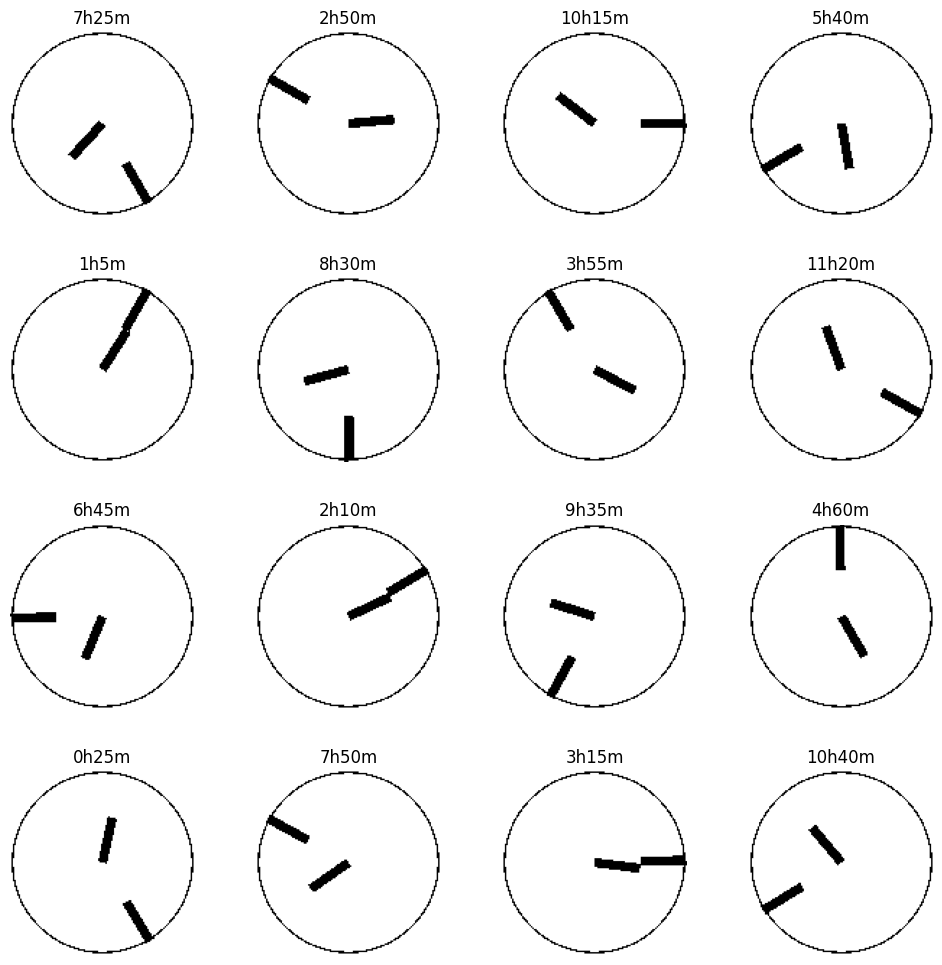

In [2]:
import torch
from torch.utils.data import DataLoader
from datasets.clock import ClockConfig, ClockDataset
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

IMG_SIZE = 128
BATCH_SIZE = 64
data_size = 4096

data_config = ClockConfig(
    minute_hand_len=1,
    minute_hand_start=0.5,
    miute_hand_thickness=0.1,
    hour_hand_len=0.5,
    hour_hand_start=0,
    hour_hand_thickness=0.1
)

dataset = ClockDataset(len=data_size, img_size=IMG_SIZE, augment=False, config=data_config)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# visualize 16 images
fig, axs = plt.subplots(4, 4, figsize=(10, 10))
fig.tight_layout()
imgs, clean_imgs, labels2d, _ = next(iter(dataloader))
for i in range(16):
    img = imgs[i].unsqueeze(0)
    label = labels2d[i].numpy()
    hour = label[0] * 12
    minute = label[1] * 60
    axs[i // 4, i % 4].imshow(img[0].squeeze(), cmap='gray')
    axs[i // 4, i % 4].set_title(f"{hour:.0f}h{minute:.0f}m")
    axs[i // 4, i % 4].axis('off')


plt.show()

dataloder efficiency

In [3]:
# from tqdm import tqdm

# dataset = ClockDataset(len=data_size, img_size=IMG_SIZE, augment=False, supervised=True, config=data_config)
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True)

# for i, b in tqdm(enumerate(dataloader), total=len(dataloader)):
#     pass

# Models

In [4]:
import os
from datasets.clock import ClockDataset, ClockConfig
import torch
from torch.utils.data import DataLoader
from config import MODELS_DIR

MODELS_DIR = 'saved_models'
LATENT_DIM = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def load_model_and_dataset(
    img_size=128,
    batch_size=64,
    data_size=2048,
    latent_dim=2,
    postfix='',
    name='model',
    data_config=None,
    checkpoint=None
):
    """
    Load the model and dataset for inference.
    """
    # Load dataset
    dataset = ClockDataset(len=data_size, img_size=img_size, augment=False, config=data_config)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Load trained model
    model_file = f"{latent_dim}-i{img_size}{postfix}"
    
    if checkpoint is None:
      model_path = os.path.join(MODELS_DIR, name, model_file, f"final.pt")
    else:
      model_path = os.path.join(MODELS_DIR, name, model_file, f"{checkpoint}.pt")
    
    model = torch.jit.load(model_path).to(device)
    model.eval()
    
    return model, dataloader

data_config = ClockConfig(
    minute_hand_len=1,
    minute_hand_start=0.5,
    miute_hand_thickness=0.1,
    hour_hand_len=0.5,
    hour_hand_start=0,
    hour_hand_thickness=0.1
)

In [11]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from tqdm import tqdm
import typing

def get_outputs(type: typing.Literal['autoencoder', 'decoder'], model, dataloader):

  torch.cuda.empty_cache()

  imgs = []
  labels1d = []
  labels2d = []
  
  latents = []
  reconstructed_imgs = []

  with torch.no_grad():
    for _, clean_imgs, label2d, label1d in dataloader:
      images = clean_imgs.to(device)
      label2d = label2d.to(device)
      
      if type == 'autoencoder':
        latent = model.encoder(images).cpu().numpy()
        latents.append(latent)
        reconstructed = model.forward(images).cpu()

      elif type == 'decoder':
        reconstructed = model.forward(label2d).cpu()
      
      label2d_unnormalized = (label2d * torch.tensor([12, 60]).to(device).float()).cpu().numpy()
      
      imgs.append(images.cpu().numpy())
      labels1d.append(label1d.numpy())
      labels2d.append(label2d_unnormalized)
      reconstructed_imgs.append(reconstructed)


    labels1d = np.concatenate(labels1d, axis=0)  # Denormalize to minutes past midnight
    labels2d = np.concatenate(labels2d, axis=0)
    imgs = np.concatenate(imgs, axis=0)
    
    reconstructed_imgs = np.concatenate(reconstructed_imgs, axis=0)
    if (type == 'autoencoder'):
      latents = np.concatenate(latents, axis=0)
  
  return imgs, latents, labels1d, labels2d, reconstructed_imgs
  
  
model, dataloader = load_model_and_dataset(
    img_size=128,
    data_config=data_config,
    latent_dim=LATENT_DIM,
    name='ResNetDecoder',
    postfix='-d21_nofc_conv',
)

type_ = 'decoder'
imgs, latents, labels1d, labels2d, reconstructed_imgs = get_outputs(type, model, dataloader)

ValueError: The provided filename saved_models/ResNetDecoder/2-i128-d21_nofc_conv/final.pt does not exist

: 

In [6]:
if type_ == 'autoencoder':
  if (LATENT_DIM <= 2):
    # Plot latent space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents[:, 0], labels1d if LATENT_DIM==1 else latents[:,1], c=labels1d, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Time in minutes past midnight")
    plt.xlabel("Latent Dimension 1")
    plt.ylabel("Time in minutes past midnight" if LATENT_DIM==1 else "Latent Dimension 2")
    plt.title("Learned Manifold of Autoencoder (Clock Dataset)")
    plt.show()
  else:
    # PCA for dimensionality reduction
    pca = PCA(n_components=2)
    latents_2d = pca.fit_transform(latents)

    # Plot PCA-reduced latent space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels1d, cmap="viridis", alpha=0.7)
    plt.colorbar(scatter, label="Time in minutes past midnight")
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    
    plt.title("Learned Manifold of Autoencoder (Clock Dataset)")
    plt.show()
    

TypeError: list indices must be integers or slices, not tuple

<Figure size 800x600 with 0 Axes>

# Decoder

In [9]:
data_iter = iter(dataloader)

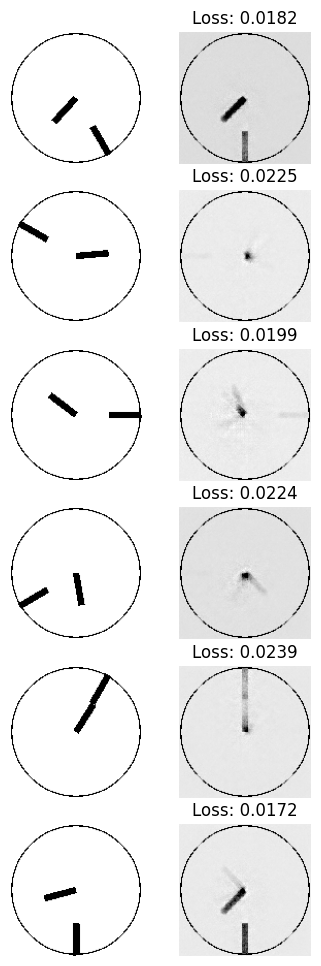

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Visualize the reconstructions
n=6
fig, axs = plt.subplots(n, 2, figsize=(2*2, n*2))
# plt.title("Original vs Reconstructed Images")

for i in range(n):
  img = imgs[i].squeeze()
  label = labels2d[i]
  reconstructed = reconstructed_imgs[i].squeeze()
  
  loss = torch.nn.functional.mse_loss(torch.tensor(imgs[i]), torch.tensor(reconstructed_imgs[i]))
  
  axs[i,0].imshow(img, cmap='gray')
  axs[i,0].axis('off')
  
  axs[i,1].imshow(reconstructed, cmap='gray')
  axs[i,1].set_title(f"Loss: {loss:.4f}")
  axs[i,1].axis('off')

plt.show()


In [15]:
from hooks.activation_norm import analyze_model_activations
from datasets.clock import ClockConfig

# Run the analysis
activation_norms = analyze_model_activations(model, dataloader, num_batches=10)

RuntimeError: The following operation failed in the TorchScript interpreter.
Traceback of TorchScript, serialized code (most recent call last):
  File "code/__torch__/models/decoders.py", line 12, in forward
    decoder_conv = self.decoder_conv
    fc = self.fc
    _0 = (decoder_conv).forward((fc).forward(x, ), )
                                 ~~~~~~~~~~~ <--- HERE
    return _0
class ConvResidualDecoderBlock(Module):
  File "code/__torch__/torch/nn/modules/container.py", line 20, in forward
    _1 = getattr(self, "1")
    _0 = getattr(self, "0")
    _6 = (_2).forward((_1).forward((_0).forward(x, ), ), )
                                    ~~~~~~~~~~~ <--- HERE
    _7 = (_5).forward((_4).forward((_3).forward(_6, ), ), )
    return _7
  File "code/__torch__/torch/nn/modules/linear.py", line 12, in forward
    bias = self.bias
    weight = self.weight
    return torch.linear(x, weight, bias)
           ~~~~~~~~~~~~ <--- HERE

Traceback of TorchScript, original code (most recent call last):
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/linear.py(125): forward
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py(1729): _slow_forward
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py(1750): _call_impl
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py(1739): _wrapped_call_impl
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/container.py(250): forward
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py(1729): _slow_forward
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py(1750): _call_impl
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py(1739): _wrapped_call_impl
/mnt/ffs24/home/moham147/experiments/manifold-learning/models/decoders.py(140): forward
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py(1729): _slow_forward
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py(1750): _call_impl
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/nn/modules/module.py(1739): _wrapped_call_impl
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/jit/_trace.py(1276): trace_module
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/jit/_trace.py(696): _trace_impl
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/jit/_trace.py(1000): trace
/mnt/ffs24/home/moham147/experiments/manifold-learning/train_utils/train.py(236): eval_and_save_model
/mnt/ffs24/home/moham147/experiments/manifold-learning/train_utils/train.py(209): _train
/mnt/ffs24/home/moham147/experiments/manifold-learning/train_utils/train.py(109): train_process
/mnt/ffs24/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/torch/multiprocessing/spawn.py(90): _wrap
/opt/software-current/2023.06/x86_64/amd/zen4/software/Python/3.11.3-GCCcore-12.3.0/lib/python3.11/multiprocessing/process.py(108): run
/opt/software-current/2023.06/x86_64/amd/zen4/software/Python/3.11.3-GCCcore-12.3.0/lib/python3.11/multiprocessing/process.py(314): _bootstrap
/opt/software-current/2023.06/x86_64/amd/zen4/software/Python/3.11.3-GCCcore-12.3.0/lib/python3.11/multiprocessing/spawn.py(133): _main
/opt/software-current/2023.06/x86_64/amd/zen4/software/Python/3.11.3-GCCcore-12.3.0/lib/python3.11/multiprocessing/spawn.py(120): spawn_main
<string>(1): <module>
RuntimeError: mat1 and mat2 shapes cannot be multiplied (8192x128 and 2x128)


In [17]:
activation_norms

defaultdict(list, {})

# Encoders

In [3]:
import torch
from config import MODELS_DIR
import numpy as np
import matplotlib.pyplot as plt

torch.set_default_device('cpu')

model, dataloader = load_model_and_dataset(
    img_size=128,
    data_config=data_config,
    latent_dim=LATENT_DIM,
    tag='DeepConvResEncoder',
    postfix='-d22',
)

imgs = []
labels1d = []
labels2d = []
reconstructed_imgs = []

with torch.no_grad():
  for images, label2d, label1d in dataloader:
    images = images.to(device)
    out = model.forward(images).cpu()
    
    label2d = (label2d * torch.tensor([12, 60]).float())
    reconstructed = (out * torch.tensor([12, 60]).float())
    
    imgs.append(images.cpu().numpy())
    labels1d.append(label1d.numpy())
    labels2d.append(label2d.numpy())
    reconstructed_imgs.append(reconstructed)
    


reconstructed_imgs = np.concatenate(reconstructed_imgs, axis=0)
labels1d = np.concatenate(labels1d, axis=0)  # Denormalize to minutes past midnight
labels2d = np.concatenate(labels2d, axis=0)
imgs = np.concatenate(imgs, axis=0)


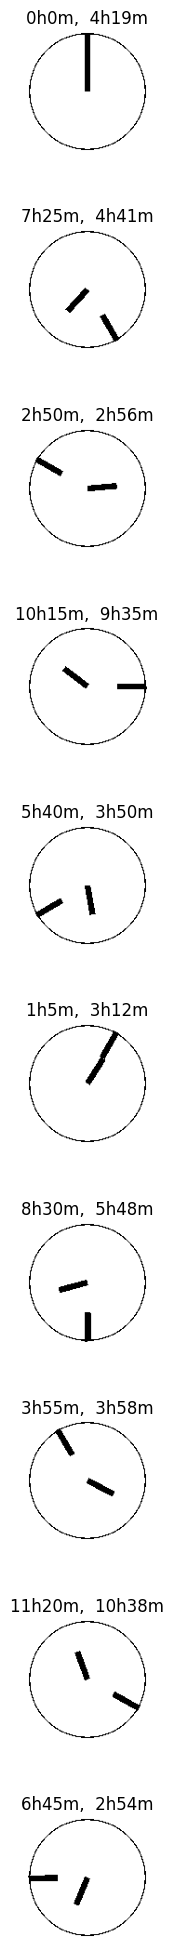

In [4]:
# Visualize the predictions
n=10
fig, axs = plt.subplots(n, 1, figsize=(2, 2*n))
fig.tight_layout()

for i in range(n):
  img = imgs[i].squeeze()
  label = labels2d[i]
  predicted_label = reconstructed_imgs[i]
  
  axs[i].imshow(img, cmap='gray')
  axs[i].set_title(f"{label[0]:.0f}h{label[1]:.0f}m,  {predicted_label[0]:.0f}h{predicted_label[1]:.0f}m")
  axs[i].axis('off')


## Attempt to predict labels using heads

Head differentiation: head1 predicts label0, head2 predicts label1.

In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# try to predict first or second label using head1 and head2
# Predict first label using head1
def fit_mlp(feat_idx, x):
  y = labels[:, feat_idx]
  x_train, x_test, y_train, y_test = train_test_split(feats_head1, y, test_size=0.2, random_state=42)
  model = MLPRegressor(hidden_layer_sizes=(128, 64), max_iter=1000)
  model.fit(x_train, y_train)

  y_pred = model.predict(x_test)
  mse = mean_squared_error(y_test, y_pred)

  print(f"Mean Squared Error (Head 1): {mse}")

fit_mlp(0, feats_head1)
fit_mlp(1, feats_head1)
fit_mlp(0, feats_head2)
fit_mlp(1, feats_head2)


Mean Squared Error (Head 1): 988.7281494140625


/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Squared Error (Head 1): 3669.49951171875
Mean Squared Error (Head 1): 879.5015869140625
Mean Squared Error (Head 1): 3783.881591796875


/mnt/home/moham147/experiments/manifold-learning/.venv/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


# UMAP

(2048,)

In [ ]:
import torch.nn as nn



(torch.Size([11, 128]), torch.Size([11, 11]))